## Home Work for week 9

### Question 1

Now convert this model from Keras to TF-Lite format.

- https://github.com/alexeygrigorev/large-datasets/releases/download/wasps-bees/bees-wasps.h5

What's the size of the converted model?

    21 Mb
    43 Mb
    80 Mb
    164 Mb

In [10]:
# !wget https://github.com/alexeygrigorev/large-datasets/releases/download/wasps-bees/bees-wasps.h5

In [25]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.lite as tflite
import numpy as np

In [16]:
bw_model = "bw-model.h5"

In [17]:
# load model
model = keras.models.load_model(bw_model)

In [18]:
# convert model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tf_lite_model = converter.convert()

with open('bw.tflite', 'wb') as f_out:
    f_out.write(tf_lite_model)

INFO:tensorflow:Assets written to: C:\Users\dawut\AppData\Local\Temp\tmpwtdy69h9\assets


INFO:tensorflow:Assets written to: C:\Users\dawut\AppData\Local\Temp\tmpwtdy69h9\assets


### Question 2

To be able to use this model, we need to know the index of the input and the index of the output.

What's the output index for this model?

    3
    7
    13
    24

In [19]:
# Load model
interpreter = tflite.Interpreter(model_path='bw.tflite')

# load weights
interpreter.allocate_tensors()

In [20]:
# check inputs
interpreter.get_input_details()

[{'name': 'serving_default_conv2d_input:0',
  'index': 0,
  'shape': array([  1, 150, 150,   3]),
  'shape_signature': array([ -1, 150, 150,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [21]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 13,
  'shape': array([1, 1]),
  'shape_signature': array([-1,  1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [56]:
interpreter.get_output_details()[0]['index']

13

In [67]:
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

### Preparing the Image

In [22]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

Let's download and resize this image:

https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg

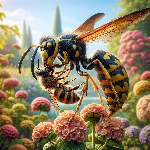

In [57]:
img_url = 'https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg'
img = download_image(img_url)
img = prepare_image(img, (150, 150))
img

### Question 3

Now we need to turn the image into numpy array and pre-process it.

    Tip: Check the previous homework. What was the pre-processing we did there?

After the pre-processing, what's the value in the first pixel, the R channel?

    0.3450980
    0.5450980
    0.7450980
    0.9450980

In [64]:
def preprocess_input(x):
    return x / 255.0

In [65]:
# convert image into an array
x = np.array(img, dtype='float32')

# turn image into a batch of 1 image
X = np.array([x])
X =  preprocess_input(X)

In [66]:
X[0, 0, 0, 0]

0.94509804

### Question 4

Now let's apply this model to this image. What's the output of the model?

    0.258
    0.458
    0.658
    0.858

In [68]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [69]:
preds

array([[0.6592138]], dtype=float32)

### Prepare the lambda code

Now you need to copy all the code into a separate python file. You will need to use this file for the next two questions.

Tip: you can test this file locally with ipython or Jupyter Notebook by importing the file and invoking the function from this file.
Docker

For the next two questions, we'll use a Docker image that we already prepared. This is the Dockerfile that we used for creating the image:

FROM public.ecr.aws/lambda/python:3.10
COPY bees-wasps-v2.tflite .

And pushed it to agrigorev/zoomcamp-bees-wasps:v2.

A few notes:

    The image already contains a model and it's not the same model as the one we used for questions 1-4.
    The version of Python is 3.10, so you need to use the right wheel for TF-Lite. For Tensorflow 2.14.0, it's https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.14.0-cp310-cp310-linux_x86_64.whl


### Question 5: Docker image size
*
162 Mb
362 Mb
662 Mb
962 Mb

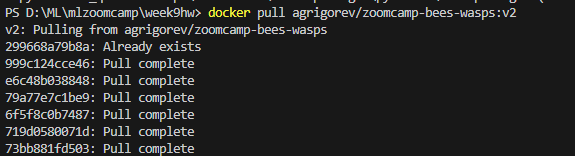

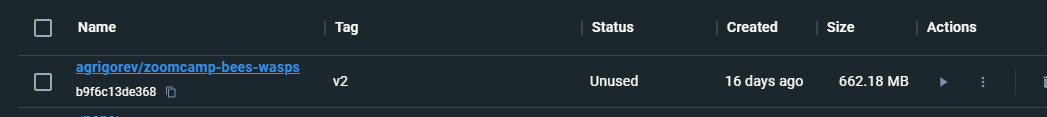

### Question 6

Now let's extend this docker image, install all the required libraries and add the code for lambda.

You don't need to include the model in the image. It's already included. The name of the file with the model is bees-wasps-v2.tflite and it's in the current workdir in the image (see the Dockerfile above for the reference). The provided model requires the same preprocessing for images regarding target size and rescaling the value range than used in homework 8.

Now run the container locally.

Score this image: https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg

What's the output from the model?

    0.2453
    0.4453
    0.6453
    0.8453

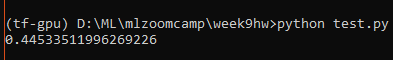